In [1]:
import numpy
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from importlib import reload
import InputList
import BinaryReader
import Preprocessor
import models
import Callbacks

2022-02-08 11:28:37.509589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [50]:
reload(InputList)

<module 'InputList' from '/home/julius/dataspellprojects/oct-classifier/InputList.py'>

## Make this such that it can be used for prediction and training pipeline

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
reader = BinaryReader.BinaryReader()  # TODO: Normalizer
training_dataset, validation_dataset = reader.create_training_datasets(InputList.training_files)
preprocesser = Preprocessor.Preprocessor(training_dataset)

Num GPUs Available:  0


2022-02-08 11:28:40.965139: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-08 11:28:40.965533: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-08 11:28:40.965556: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 11:28:40.965586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zeissstudent1): /proc/driver/nvidia/version does not exist
2022-02-08 11:28:40.998990: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild Ten

In [4]:
print("Creating Normalization Layer:")
normalization_layer = preprocesser.normalize_layer()

Creating Normalization Layer:


2022-02-08 11:28:48.953530: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-08 11:28:48.974725: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


In [5]:
normalization_weights = normalization_layer.get_weights()
print("Before:" + str(normalization_weights))
normalization_weights_path = "results/normalization.npy"
np.save(normalization_weights_path, normalization_weights)
normalization_layer.set_weights(np.load(normalization_weights_path))
print("After" + str(normalization_weights))

Before:[32762.3, 4103221.0, 9891840]
After[32762.3, 4103221.0, 9891840]


In [17]:
normalization_layer.set_weights(np.array([32743.002, 5470130.0, 25706913792]))

In [6]:
model = models.classiRaw3D(training_dataset.element_spec[0].shape, normalization_layer)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536, 23, 28, 1)] 0         
_________________________________________________________________
normalization (Normalization (None, 1536, 23, 28, 1)   3         
_________________________________________________________________
permute (Permute)            (None, 1, 23, 28, 1536)   0         
_________________________________________________________________
dense (Dense)                (None, 1, 23, 28, 768)    1179648   
_________________________________________________________________
permute_1 (Permute)          (None, 768, 23, 28, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 768, 23, 28, 32)   896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 384, 11, 14, 32)   0     

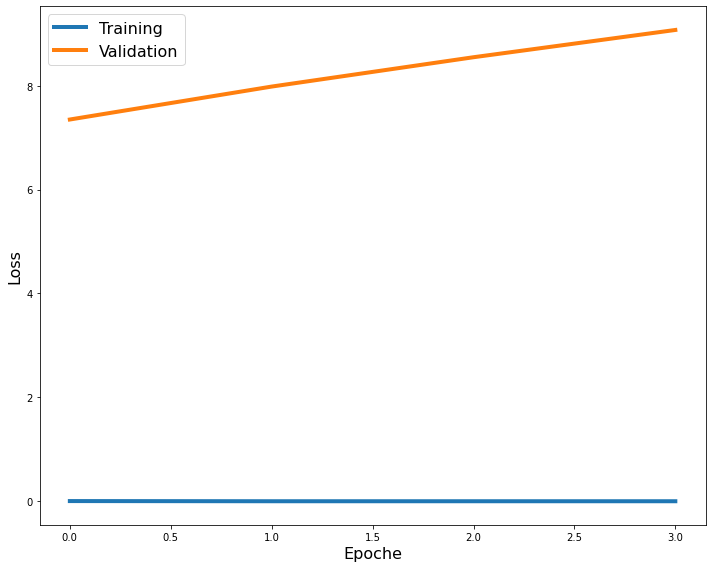

Epoch 5/30
2599/2599 [==============================] - ETA: 0s - loss: 7.1100e-11 - sparse_categorical_crossentropy: 7.1100e-11

In [ ]:
history = model.fit(
    preprocesser.batch(20),
    epochs=30,
    validation_data=Preprocessor.Preprocessor(validation_dataset).batch(20),
    callbacks=Callbacks.my_callbacks
)
model.save('savedModels/first')

In [64]:
reload(models)
model = models.classiRaw3D(training_dataset.element_spec[0].shape, normalization_layer, reconstruction=False)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1536, 23, 28, 1)] 0         
_________________________________________________________________
normalization (Normalization (None, 1536, 23, 28, 1)   3         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 1536, 23, 28, 64)  1792      
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 768, 11, 14, 64)   0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 768, 11, 14, 128)  221312    
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 384, 5, 7, 128)    0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 384, 5, 7, 192)    6637

In [224]:
training_dataset

<PrefetchDataset shapes: ((1536, 23, 28, 1), ()), types: (tf.uint16, tf.uint8)>

In [8]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [18]:
model.load_weights("checkpoints/best_model")

In [12]:
with open("checkpoints/best_model.data-00000-of-00001") as testi:
    print(testi)

<_io.TextIOWrapper name='checkpoints/best_model.data-00000-of-00001' mode='r' encoding='UTF-8'>


print_function(Bag Number, dataset)

-> In einem Bag sind 7000 Instanzen

# Bag Level Model:

Ich hab ganz viele Softmaxes und von denen nehm ich einfach den Max Wert

In [68]:
test_dataset = reader.create_test_dataset([InputList.diabetic_training_files[4]])
output = model.predict(test_dataset.batch(20))

2022-02-08 18:00:53.002220: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:00:57.834422: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:03.134897: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:08.671641: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.
2022-02-08 18:01:14.168709: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 5064622080 exceeds 10% of free system memory.


In [67]:
prediction_file = InputList.diabetic_training_files[4]

Linearisierung:

In [66]:
normalized = normalization_layer(test_dataset).batch(20)

ValueError: Attempt to convert a value (<PrefetchDataset shapes: ((1536, 23, 28, 1), ()), types: (tf.uint16, tf.uint8)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>) to a Tensor.

In [56]:
output

array([[1.5320530e-12, 1.0000000e+00],
       [3.6272407e-13, 1.0000000e+00],
       [5.2061959e-14, 1.0000000e+00],
       ...,
       [2.7368467e-13, 1.0000000e+00],
       [3.6967787e-13, 1.0000000e+00],
       [4.5514542e-13, 1.0000000e+00]], dtype=float32)

In [24]:
73*89

6497

In [28]:
import math
round(output[1,0],2)

0.0

In [34]:
round(output[4500,0],5)

0.0

In [57]:
np.mean(output[:,1])

1.0

array([[2.7189600e-12, 1.0000000e+00],
       [3.0085756e-12, 1.0000000e+00],
       [2.3979503e-12, 1.0000000e+00],
       ...,
       [1.1708659e-11, 1.0000000e+00],
       [4.0693295e-12, 1.0000000e+00],
       [2.3206693e-12, 1.0000000e+00]], dtype=float32)